# Multi-class Multi-label Patent Classification with Hybrid Neural Networks

### *Saurav Datta, Arvindh Ganesan, Christina Papadimitriou*
*August 7th, 2018*

In [2]:
# import packages 
import tensorflow as tf
import pandas as pd  
import numpy as np 
import gzip
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Activation, Dropout, Input, Embedding, Bidirectional, Reshape, Flatten, Conv1D, MaxPooling1D, MaxPool1D, GlobalMaxPool1D, SpatialDropout1D
from keras.preprocessing import text, sequence
from keras import utils
from keras import callbacks
from keras import optimizers, models
from sklearn import model_selection, preprocessing, metrics
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import zipfile
import keras_metrics

import nltk
import re

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext memory_profiler

### Loading the Data

Dataset: 

https://www.google.com/googlebooks/uspto-patents-grants-text.html#2015

The parsing and preprocessing of the patent files can be found here: 

https://github.com/cpapadimitriou/W266-Final-Project/blob/master/preparation/parse_xml.py

In [3]:
# load data 

# features 
current_dir = %pwd
abstract = pd.read_table(current_dir+'/out_zipped/docNumberToAbsText.txt.gz',compression='gzip', header=None)
abstract = abstract[0].str.split('|', expand=True).rename(columns={0:'doc_num',1:'abstract'})

claim = pd.read_table(current_dir+'/out_zipped/docNumberToClaimText.txt.gz',compression='gzip',  header=None)
claim = claim[0].str.split('|', expand=True).rename(columns={0:'doc_num',1:'claim'})

desc = pd.read_table(current_dir+'/out_zipped/docNumberToDescText.txt.gz',compression='gzip', header=None)
desc = desc[0].str.split('|', expand=True).rename(columns={0:'doc_num',1:'desc'})

title = pd.read_table(current_dir+'/out_zipped/docNumberToInvTitle.txt.gz',compression='gzip', header=None)
title = title[0].str.split('|', expand=True).rename(columns={0:'doc_num',1:'title'})

# file_name = pd.read_table(current_dir+'/out_zipped/fileNameToDocNumber.txt.gz',compression='gzip', header=None)
# file_name = file_name[0].str.split('|', expand=True).rename(columns={0:'file_name',1:'doc_num'})

In [4]:
# labels 
# label_names = pd.read_table(current_dir+'/out_zipped/docNumberToLabelSubClass.txt.gz',compression='gzip', header=None)
# label_names = labels[0].str.split('|', expand=True).rename(columns={0:'doc_num'})

labels = pd.read_table(current_dir+'/out_zipped/docNumberToLabelSubClassCode.txt.gz',compression='gzip', header=None)
labels = labels[0].str.split('|', expand=True).rename(columns={0:'doc_num'})

### Data Preparation

In [5]:
# joining the datasets
X = pd.concat([title.set_index('doc_num'), 
           abstract.set_index('doc_num'), 
           claim.set_index('doc_num'), 
           desc.set_index('doc_num')], axis=1).sort_index() #  join='inner'

Y = labels.set_index('doc_num').sort_index() #.set_index(X.index) # fixing the index mismatch
Y.columns=["label{}".format(i) for i in range(1,9)] # renaming columns 

print(X.shape)
print(Y.shape)

(78372, 4)
(78372, 8)


In [6]:
X.head()

,title,abstract,claim,desc
doc_num,,,,
0000001,INTEGRAL MULTIFUNCTIONAL SYSTEM FOR MOTOR VEHICLE,The system finds application with the motor ve...,CLAIMS 1. Integral multifunctional system for ...,INTEGRAL MULTIFUNCTIONAL SYSTEM FOR MOTOR VEHI...
0000002,TURBINE DRIVEN WITH A FLUID MEDIUM,Turbine driven by a flowing medium to generate...,Claims 1. Turbine driven by a flowing medium t...,TURBINE DRIVEN WITH A FLUID MEDIUM. Technical ...
0000003,METHOD TO REMOVE LEAKAGE PROBLEMS IN PIPES PRO...,Method to remove leakage problems in pipes pro...,CLAIMS Claim 1 ) A new method in which choke a...,SPECIFICATION METHOD TO REMOVE LEAKAGE PROBLEM...
0000004,PRESSURE RELEASE VALVE,A pressure release valve is disclosed ideally ...,CLAIMS 1. A pressure release valve comprising ...,Pressure Release Valve This invention relates ...
0000005,ROLL-OVER MECHANISM FOR A PRESSURE RELEASE VALVE,A rollover mechanism for a pressure valve is d...,"CLAIMS 1. A roll-over mechanism for a valve, s...",Roll-over mechanism for a pressure release val...


In [7]:
Y.head()

,label1,label2,label3,label4,label5,label6,label7,label8
doc_num,,,,,,,,
0000001,F02B,None,None,None,None,None,None,None
0000002,F03D,F03B,None,None,None,None,None,None
0000003,F16L,None,None,None,None,None,None,None
0000004,F16K,None,None,None,None,None,None,None
0000005,F16K,None,None,None,None,None,None,None


In [8]:
# data cleaning 
assert Y['label1'].isnull().sum() == 0 # there is no document with 

print("{} documents with null title".format(X['title'].isnull().sum()))
print("{} documents with null claims".format(X['claim'].isnull().sum()))
print("{} documents with null abstract".format(X['abstract'].isnull().sum()))
print("{} documents with null description".format(X['desc'].isnull().sum()))

# remove documents with null sections (title and abstract)
X_clean = X.dropna(how='any')
null_idx = X[~X.index.isin(X_clean.index)].index # storing the removed indices (i.e. document numbers)
assert X.shape[0] - null_idx.shape[0] == X_clean.shape[0] # making sure the row counts match

# removing the documents with null sections from the labels as well 
Y_clean = Y.loc[X_clean.index]

# some checks
assert X_clean.shape[0] == Y_clean.shape[0]
assert ((Y_clean.index == X_clean.index)*1).sum() == X_clean.shape[0]

# lower-casing everything
X_clean = X_clean.apply(lambda x: x.str.lower())
Y_clean = Y_clean.apply(lambda x: x.str.lower())

0 documents with null title
0 documents with null claims
0 documents with null abstract
0 documents with null description


In [9]:
print(X_clean.shape)
print(Y_clean.shape)

(78372, 4)
(78372, 8)


In [10]:
X_clean.head()

,title,abstract,claim,desc
doc_num,,,,
0000001,integral multifunctional system for motor vehicle,the system finds application with the motor ve...,claims 1. integral multifunctional system for ...,integral multifunctional system for motor vehi...
0000002,turbine driven with a fluid medium,turbine driven by a flowing medium to generate...,claims 1. turbine driven by a flowing medium t...,turbine driven with a fluid medium. technical ...
0000003,method to remove leakage problems in pipes pro...,method to remove leakage problems in pipes pro...,claims claim 1 ) a new method in which choke a...,specification method to remove leakage problem...
0000004,pressure release valve,a pressure release valve is disclosed ideally ...,claims 1. a pressure release valve comprising ...,pressure release valve this invention relates ...
0000005,roll-over mechanism for a pressure release valve,a rollover mechanism for a pressure valve is d...,"claims 1. a roll-over mechanism for a valve, s...",roll-over mechanism for a pressure release val...


In [11]:
Y_clean.head()

,label1,label2,label3,label4,label5,label6,label7,label8
doc_num,,,,,,,,
0000001,f02b,None,None,None,None,None,None,None
0000002,f03d,f03b,None,None,None,None,None,None
0000003,f16l,None,None,None,None,None,None,None
0000004,f16k,None,None,None,None,None,None,None
0000005,f16k,None,None,None,None,None,None,None


In [11]:
# Creating dataset 
data = pd.DataFrame()

# concat the text of all patent sections and join the labels
data['full_text'] = X_clean['title'] + " " + X_clean['claim'] + " " + X_clean['abstract'] + " " + X_clean['desc']

# using only the first label  
data['label1'] = Y_clean['label1'] 

# using all labels, merging them in a list and removing None values
data['labels'] = Y_clean.values.tolist()
data['labels'] = data['labels'].apply(lambda x: list(filter(None, x)))

In [12]:
data.head()

,full_text,label1,labels
doc_num,,,
0000001,integral multifunctional system for motor vehi...,f02b,[f02b]
0000002,turbine driven with a fluid medium claims 1. t...,f03d,"[f03d, f03b]"
0000003,method to remove leakage problems in pipes pro...,f16l,[f16l]
0000004,pressure release valve claims 1. a pressure re...,f16k,[f16k]
0000005,roll-over mechanism for a pressure release val...,f16k,[f16k]


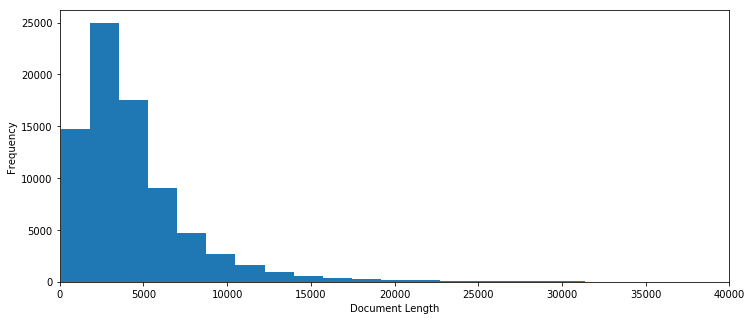

In [14]:
# histogram of document length 
doc_lenghts = data.full_text.str.split().apply(lambda x: len(x))
plt.figure(figsize=(12,5))
plt.hist(doc_lenghts, bins=100)
plt.xlim((0,40000))
plt.xlabel('Document Length')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Bokeh for plotting.
import bokeh.plotting as bp
from bokeh.models import HoverTool
bp.output_notebook()

# Helper code for plotting histograms
def plot_length_histogram(lengths, x_range=[0,40000], bins=40, normed=False):
    hist, bin_edges = np.histogram(a=lengths, bins=bins, normed=normed, range=x_range)
    bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
    bin_widths =  (bin_edges[1:] - bin_edges[:-1])

    hover = HoverTool(tooltips=[("bucket", "@x"), ("count", "@top")], mode="vline")
    fig = bp.figure(plot_width=800, plot_height=400, tools=[hover])
    fig.vbar(x=bin_centers, width=bin_widths, top=hist, hover_fill_color="firebrick")
    fig.y_range.start = 0
    fig.x_range.start = 0
    fig.xaxis.axis_label = "Document Length"
    fig.yaxis.axis_label = "Frequency"
    bp.output_file("hist.html")
    bp.show(fig)
    
plot_length_histogram(doc_lenghts)

In [16]:
# examing the document length 
print("Average document length: {} words".format(round(np.mean(doc_lenghts))))
print("Median document length: {} words".format(round(np.median(doc_lenghts))))
print("Max document length: {} words".format(round(np.max(doc_lenghts))))
print("Min document length: {} words".format(round(np.min(doc_lenghts))))

Average document length: 4433 words
Median document length: 3488.0 words
Max document length: 174233 words
Min document length: 48 words


In [17]:
# average number of labels per document 
print("Avg. number of labels in dataset: {}".format(data['labels'].apply(lambda x: len(x)).mean()))

Avg. number of labels in dataset: 1.394949726943296


#### Note: we remove documents with less than 200 words

In [18]:
# filtering out documents with fewer words 
data["doc_lenghts"] = data.full_text.str.split().apply(lambda x: len(x))

In [19]:
# data[data["doc_lenghts"]<200].shape

In [20]:
data.shape

(78372, 4)

In [21]:
data = data[data["doc_lenghts"]>200]

In [22]:
data.shape

(78172, 4)

### Encoding Labels with MultiLabelBinarizer

In [23]:
data['labels'].head()

doc_num
0000001          [f02b]
0000002    [f03d, f03b]
0000003          [f16l]
0000004          [f16k]
0000005          [f16k]
Name: labels, dtype: object

In [24]:
# converting labels into a binarized matrix with the labels as columns 
# and each patent document represented in one row
mlb = preprocessing.MultiLabelBinarizer()
labels = mlb.fit_transform(data['labels'])

# checking that the conversion worked as desired by verifying the counts of labels for each document prior and post 
assert data['labels'].apply(lambda x: len(x)).values.sum() == np.array(pd.DataFrame(labels).apply(lambda x: x.sum(),axis=1)).sum()

In [25]:
# labels_df.iloc[:,[538]].sum()   #470

In [26]:
labels_df = pd.DataFrame(labels, columns=mlb.classes_)  #.apply(lambda x: x.sum(),axis=1)
labels_df.head()

,f01b,f01c,f01d,f01k,f01l,f01m,f01n,f01p,f02b,f02c,...,f41a,f41b,f41c,f41f,f41g,f41h,f41j,f42b,f42c,f42d
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
print("We have {} classes".format(len(mlb.classes_)))
# print("")
# for i in mlb.classes_: 
#     print(i)

We have 96 classes


In [29]:
# checking how many times does each label (i.e. class) appear in the data 
# we observe that the classes are a little unbalanced 
pl = labels_df.apply(lambda x: x.sum(),axis=0).sort_values(ascending=False)  #.plot.bar()

In [30]:
pl.head(10)

f16h    6030
f16l    5606
f02b    5209
f16k    4528
f02d    4504
f16d    4265
f02m    4262
f16c    3541
f16b    3447
f04b    3311
dtype: int64

In [31]:
pl.tail(10)

f41f    84
f16t    77
f22d    58
f03h    52
f23h    50
f16s    47
f22g    40
f23b    34
f21h     6
f17b     6
dtype: int64

In [ ]:
from bokeh.io import show, output_file
from bokeh.plotting import figure
import bokeh.plotting as bp
bp.output_notebook()

output_file("bars.html")
p = figure(x_range=list(pl.index), plot_height=250, title="Label Counts",
           toolbar_location=None, tools="")
p.vbar(x=list(pl.index), top=pl.values, width=0.1)
p.xgrid.grid_line_color = None
p.y_range.start = 0
show(p)

### Advanced text processing and TF_IDF 
The following processing was applied to `data['full_text']`:

- removing punctuation 
- lowercasing
- removing stop words 
- romoving common / rare words (did not run this)
- lemmatization or stemming (we chose lemmatization)
- remove digits
- filtering 600 best words in each document based on tf_idf algorithm 

Future: 
- Detect and Remove non-english documents 

In [32]:
data['full_text'].head(10)

doc_num
0000001    integral multifunctional system for motor vehi...
0000002    turbine driven with a fluid medium claims 1. t...
0000003    method to remove leakage problems in pipes pro...
0000004    pressure release valve claims 1. a pressure re...
0000005    roll-over mechanism for a pressure release val...
0000007    device by ball valve c l a i m s 1. a valve, i...
0000008    composite electroconducting material claims 1....
0000009    process and apparatus for agglomeration of pow...
0000011    heating unit for rock material claims 1. a hea...
0000012    a method and apparatus for microwave processin...
Name: full_text, dtype: object

### 1. Advanced Processing

In [42]:
# removing punctuation 
data['full_text_proc'] = data['full_text'].str.replace('[^\w\s]','')
data['full_text_proc'].head(10)

doc_num
0000001    integral multifunctional system for motor vehi...
0000002    turbine driven with a fluid medium claims 1 tu...
0000003    method to remove leakage problems in pipes pro...
0000004    pressure release valve claims 1 a pressure rel...
0000005    rollover mechanism for a pressure release valv...
0000007    device by ball valve c l a i m s 1 a valve in ...
0000008    composite electroconducting material claims 1 ...
0000009    process and apparatus for agglomeration of pow...
0000011    heating unit for rock material claims 1 a heat...
0000012    a method and apparatus for microwave processin...
Name: full_text_proc, dtype: object

In [ ]:
# lower - casing 
data['full_text_proc'] = data['full_text_proc'].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [43]:
# removing stop words 

nltk.download('stopwords')
# stop = nltk.corpus.stopwords.words('english')
# data['full_text_proc'] = data['full_text_proc'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
# data['full_text_proc'].head()
stop = nltk.corpus.stopwords.words('english')
pattern_stop = r'\b(?:{})\b'.format('|'.join(stop))
data['full_text_proc_no_stop'] = data['full_text_proc'].str.replace(pattern_stop, '')
data['full_text_proc_no_stop'] = data['full_text_proc_no_stop'].str.replace(r'\s+', ' ')
data['full_text_proc'] = data['full_text_proc_no_stop']

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/c.papadimitriou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Note: we will not run common and rare word removal cells. This will be taken care of with TF-IDF later. 

In [ ]:
# Common word removal 
# we can remove common words as their presence will not be of any use for our classification problem 
freq_words = pd.Series(' '.join(data['full_text_proc']).split()).value_counts()[:10] # chose the number here 
freq_words

In [ ]:
# Decide if we want to remove these
freq_words = list(freq_words.index)
pattern_freq_words = r'\b(?:{})\b'.format('|'.join(freq_words))

data['full_text_proc'] = data['full_text_proc'].replace(to_replace=pattern_freq_words, value="",regex=True)
data['full_text_proc'] = data['full_text_proc'].str.replace(r'\s+', ' ')

In [38]:
# Rare word removal 
# Similarly, just as we removed the most common words, this time let’s remove rarely occurring words from the text. 
# Because they’re so rare, the association between them and other words is dominated by noise. 
rare_words = pd.Series(' '.join(data['full_text_proc']).split()).value_counts()[-10:]
rare_words

tetrastearate    1
atmio16de10      1
carottier        1
tesse            1
rastlippen       1
9624705          1
albe             1
carimali         1
65gcm3           1
tremities        1
dtype: int64

In [41]:
rare_words = list(rare_words.index)
pattern_rare_words = r'\b(?:{})\b'.format('|'.join(rare_words))
data['full_text_proc'] = data['full_text_proc'].replace(to_replace=pattern_rare_words, value="",regex=True)
data['full_text_proc'] = data['full_text_proc'].str.replace(r'\s+', ' ')

In [21]:
data['full_text_proc'].head()

doc_num
0000001    integral multifunctional system motor vehicle ...
0000002    turbine driven fluid medium claims 1 turbine d...
0000003    method remove leakage problems pipes produced ...
0000004    pressure release valve claims 1 pressure relea...
0000005    rollover mechanism pressure release valve clai...
Name: full_text_proc, dtype: object

In [ ]:
# Spelling correction (this will take a while to run - lets think if we need it. Maybe fo the foreign language words?)
# Maybe there is another library to remove foreign language text? 

# from textblob import TextBlob
# data['full_text_proc'] = data['full_text_proc'][:5].apply(lambda x: str(TextBlob(x).correct()))

In [ ]:
# Stemming: removal of suffices, like “ing”, “ly”, “s”, etc.
# from nltk.stem import PorterStemmer
# st = PorterStemmer()
# data['full_text_proc'] = data['full_text_proc'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

In [48]:
# Lemmatization: converts the word into its root word, rather than just stripping the suffices.
# use this instead of stemming 
nltk.download('wordnet')

from textblob import Word
data['full_text_proc'] = data['full_text_proc'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
data['full_text_proc'].head()

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/c.papadimitriou/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


doc_num
0000001    integral multifunctional system motor vehicle ...
0000002    turbine driven fluid medium claim 1 turbine dr...
0000003    method remove leakage problem pipe produced pl...
0000004    pressure release valve claim 1 pressure releas...
0000005    rollover mechanism pressure release valve clai...
Name: full_text_proc, dtype: object

In [51]:
# Remove Digits 
import re
data['full_text_proc'] = data['full_text_proc'].apply(lambda x : re.sub("\d+", "", x))

### PICKLE CHECKPOINT:

In [53]:
# SAVE
data.to_pickle('./saved_df_zipped/data_after_advanced_proc.pkl.gz', compression='gzip')

# LOAD
# data = pd.DataFrame()
# data = pd.read_pickle("./saved_df_zipped/data_after_advanced_proc.pkl.gz", compression='gzip')
# data.info()
# data.head

In [54]:
data.head()

,full_text,label1,labels,doc_lenghts,full_text_proc,full_text_proc_no_stop
doc_num,,,,,,
0000001,integral multifunctional system for motor vehi...,f02b,[f02b],6385,integral multifunctional system motor vehicle ...,integral multifunctional system motor vehicle ...
0000002,turbine driven with a fluid medium claims 1. t...,f03d,"[f03d, f03b]",3236,turbine driven fluid medium claim turbine dri...,turbine driven fluid medium claims 1 turbine d...
0000003,method to remove leakage problems in pipes pro...,f16l,[f16l],645,method remove leakage problem pipe produced pl...,method remove leakage problems pipes produced ...
0000004,pressure release valve claims 1. a pressure re...,f16k,[f16k],2967,pressure release valve claim pressure release...,pressure release valve claims 1 pressure relea...
0000005,roll-over mechanism for a pressure release val...,f16k,[f16k],3711,rollover mechanism pressure release valve clai...,rollover mechanism pressure release valve clai...


### 2. TF-IDF 

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [56]:
max_length = 600
col_names =  ['i','top_words']
data_tfidf  = pd.DataFrame(columns = col_names)

In [57]:
data['full_text_proc'].head()

doc_num
0000001    integral multifunctional system motor vehicle ...
0000002    turbine driven fluid medium claim  turbine dri...
0000003    method remove leakage problem pipe produced pl...
0000004    pressure release valve claim  pressure release...
0000005    rollover mechanism pressure release valve clai...
Name: full_text_proc, dtype: object

In [58]:
# TF-IDF to eliminate word count
# We can also perform basic pre-processing steps like lower-casing and removal of stopwords (but we did this earlier)

tfidf = TfidfVectorizer(lowercase=True, analyzer='word', smooth_idf=False, sublinear_tf=False, norm=None,
                        stop_words='english', ngram_range=(1,1)) 

text_transformed = tfidf.fit_transform(data['full_text_proc'])

In [59]:
import datetime
print(datetime.datetime.now())
feature_names = np.array(tfidf.get_feature_names())

for i in range(text_transformed.shape[0]):
    f_index = text_transformed[i,:].nonzero()[1]
    tfid_score = zip(f_index,[text_transformed[i,x] for x in f_index])
    
    word = []
    score = []

    for w,s in [(feature_names[i],s) for i,s in tfid_score]:
        word.append(w)
        score.append(s)
    score = np.array(score)
    word = np.array(word)
    txt = " ".join(word[(-score).argsort()[:max_length]])
    data_tfidf.loc[len(data_tfidf)] = [i,txt]
print(datetime.datetime.now())

2018-08-04 15:33:43.611360
2018-08-04 16:14:57.113929


In [61]:
data_tfidf.head()

,i,top_words
0,0,hydraulic accumulator microcomputer engine liq...
1,1,foil turbine longitual discoidal shaft angel m...
2,2,muff plasticbase choke pipe gasket clampsystem...
3,3,tanker valve rollover plunger pressure petrol ...
4,4,tanker rollover pendulum valve float petrol me...


In [72]:
data['full_text_proc_final'] = data_tfidf.set_index(data.index).top_words

In [166]:
data.head()

,full_text,label1,labels,doc_lenghts,full_text_proc,full_text_proc_no_stop,full_text_proc_final
doc_num,,,,,,,
0000001,integral multifunctional system for motor vehi...,f02b,[f02b],6385,integral multifunctional system motor vehicle ...,integral multifunctional system motor vehicle ...,hydraulic accumulator microcomputer engine liq...
0000002,turbine driven with a fluid medium claims 1. t...,f03d,"[f03d, f03b]",3236,turbine driven fluid medium claim turbine dri...,turbine driven fluid medium claims 1 turbine d...,foil turbine longitual discoidal shaft angel m...
0000003,method to remove leakage problems in pipes pro...,f16l,[f16l],645,method remove leakage problem pipe produced pl...,method remove leakage problems pipes produced ...,muff plasticbase choke pipe gasket clampsystem...
0000004,pressure release valve claims 1. a pressure re...,f16k,[f16k],2967,pressure release valve claim pressure release...,pressure release valve claims 1 pressure relea...,tanker valve rollover plunger pressure petrol ...
0000005,roll-over mechanism for a pressure release val...,f16k,[f16k],3711,rollover mechanism pressure release valve clai...,rollover mechanism pressure release valve clai...,tanker rollover pendulum valve float petrol me...


In [136]:
#data.reset_index()[data.reset_index().doc_num=='85110305']
# data.reset_index()[data.reset_index().doc_num=='0000007']
# data.reset_index()[data.reset_index().doc_num=='85110305'].full_text_proc_final.values
# data.reset_index()[data.reset_index().doc_num=='85110305'].full_text.values

### PICKLE CHECKPOINT:

In [49]:
# SAVE
# data.to_pickle('./saved_df_zipped/data_after_tfidf.pkl.gz', compression='gzip')

# LOAD
data = pd.DataFrame()
data = pd.read_pickle("./saved_df_zipped/data_after_tfidf.pkl.gz", compression='gzip')
data.info()
#data.head

<class 'pandas.core.frame.DataFrame'>
Index: 78172 entries, 0000001 to 99974199
Data columns (total 7 columns):
full_text                 78172 non-null object
label1                    78172 non-null object
labels                    78172 non-null object
doc_lenghts               78172 non-null int64
full_text_proc            78172 non-null object
full_text_proc_no_stop    78172 non-null object
full_text_proc_final      78172 non-null object
dtypes: int64(1), object(6)
memory usage: 4.8+ MB


In [ ]:
# OLD TFIDF ATTEMPT
# tfidf = TfidfVectorizer(lowercase=True, analyzer='word', smooth_idf=False, sublinear_tf=False, norm=None,
#                         stop_words='english', ngram_range=(1,1)) 

# text_transformed = tfidf.fit_transform(data['full_text_proc']).toarray() # CHANGE THIS TO ALL DOCS
# feature_names = np.array(tfidf.get_feature_names())
# test_words = feature_names[np.argsort(text_transformed)][:,-max_length:]

# z = []
# for i,t in (enumerate(list(test_words))):
#     a = (set(t))
#     b = (set(re.sub("[^\w]", " ",  (data['full_text_proc'][:20000][i])).split()))
#     z.append(list(a.intersection(b)))

# data['full_text_proc_final'] = pd.Series(z, index=data.index).apply(lambda x : " ".join(x))

#### Examining document length distribution after tfidf 

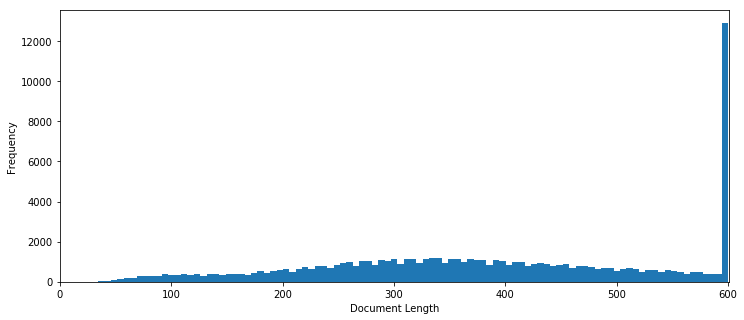

In [35]:
# histogram of document length 
doc_lenghts_tfidf = data.full_text_proc_final.str.split().apply(lambda x: len(x))
plt.figure(figsize=(12,5))
plt.hist(doc_lenghts_tfidf, bins=100)
plt.xlim((0,601))
plt.xlabel('Document Length')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Bokeh for plotting.
import bokeh.plotting as bp
from bokeh.models import HoverTool
bp.output_notebook()

# Helper code for plotting histograms
def plot_length_histogram(lengths, x_range=[0,600], bins=40, normed=False):
    hist, bin_edges = np.histogram(a=lengths, bins=bins, normed=normed, range=x_range)
    bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
    bin_widths =  (bin_edges[1:] - bin_edges[:-1])

    hover = HoverTool(tooltips=[("bucket", "@x"), ("count", "@top")], mode="vline")
    fig = bp.figure(plot_width=800, plot_height=400, tools=[hover])
    fig.vbar(x=bin_centers, width=bin_widths, top=hist, hover_fill_color="firebrick")
    fig.y_range.start = 0
    fig.x_range.start = 0
    fig.xaxis.axis_label = "Document Length"
    fig.yaxis.axis_label = "Frequency"
    bp.output_file("hist_tfidf.html")
    bp.show(fig)
    
plot_length_histogram(doc_lenghts_tfidf)

In [36]:
print("Average document length: {} words".format(round(np.mean(doc_lenghts_tfidf))))
print("Median document length: {} words".format(round(np.median(doc_lenghts_tfidf))))
print("Max document length: {} words".format(round(np.max(doc_lenghts_tfidf))))
print("Min document length: {} words".format(round(np.min(doc_lenghts_tfidf))))

Average document length: 386 words
Median document length: 380.0 words
Max document length: 600 words
Min document length: 29 words


### Train Test Split

In [50]:
# train test split 
# you can change to data['label1'] to include only the first label 
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(data['full_text_proc_final'], labels, test_size=0.2)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(62537,)
(15635,)
(62537, 96)
(15635, 96)


In [51]:
X_train.head()

doc_num
9801511     pendulum piston motor wheel pressure medium ch...
97201796    seat valve seattoclosure seal closure cavity m...
84102052    wendel der warmwasserspeicher und rohrzug folg...
9800231     neck said nut thread portion ring shank workpi...
87113143    porous screw static plating body lead guide ma...
Name: full_text_proc_final, dtype: object

In [175]:
# print("Avg. number of labels in train set: {}".format(Y_train.apply(lambda x: len(x)).mean()))
# print("Avg. number of labels in test set: {}".format(Y_test.apply(lambda x: len(x)).mean()))

### Word Embeddings

### 1. Loading pre-trained Embeddings

**Load the pre-trained embeddings using this command:**

`nohup curl -O https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki-news-300d-1M.vec.zip > curl.nohup.out 2>&1 &`

Check loading progress with this: `cat curl.nohup.out`

Unzipping the file with python: 

In [52]:
# sequence length is set to 600 (we will choose the 600 most frequent words in each document)
sequence_length = 600
embedding_dim = 300

In [15]:
# DO NOT RUN IF USING OUR TRAINED EMBEDDINGS 

# word-embeddings: representing documents using a dense vector representation
# Word embeddings can be trained using the input corpus itself or 
# can be generated using pre-trained word embeddings such as Glove, FastText, and Word2Vec

# step 1. Loading the pretrained word embeddings

df_tmp1=pd.read_table('../wiki-news-300d-1M.vec.zip', compression='zip', sep='\s+', header=None, engine='python', skiprows=1)
columns=['word', 'vector']
df_tmp2=pd.DataFrame(columns=columns)
df_tmp2['word']=df_tmp1[df_tmp1.columns[0]]
df_tmp2['vector']=np.asarray(df_tmp1[df_tmp1.columns[1:]], dtype='float32').tolist()
embeddings_index=pd.Series(df_tmp2.vector.values, index=df_tmp2.word).to_dict()

Link to Tokenizer keras object: https://keras.io/preprocessing/text/

This takes care of:
- num of words to keep based on frequency (`num_words`).
- filtering out punctuation: The **default** is all punctuation, plus tabs and line breaks, minus the ' character.
- lower-casing: convert the texts to lowercase.

In [83]:
# step 2. Creating a tokenizer object using Keras preprocessing object
# the tokenizer has a default filter that removes all punctuation, plus tabs and line breaks, minus the ' character.
token = text.Tokenizer(filters='.') # num_words=sequence_length lower=True
token.fit_on_texts(data['full_text_proc']) # full_text_proc
word_index = token.word_index

In [84]:
print('Number of words in our vocabulary: {}'.format(len(word_index.keys())))

Number of words in our vocabulary: 565769


In [85]:
# step 3. Transforming text documents to sequence of tokens and padding them to ensure equal length vectors
# choosing the median document length as max length for padding 
X_train_seq = sequence.pad_sequences(token.texts_to_sequences(X_train), maxlen=sequence_length)
X_test_seq = sequence.pad_sequences(token.texts_to_sequences(X_test), maxlen=sequence_length)

In [86]:
# checking out what this did to the first patent
#X_train_seq[0]

In [87]:
print(X_train_seq.shape)
print(X_test_seq.shape)

(62537, 600)
(15635, 600)


In [ ]:
# DO NOT RUN IF USING OUR TRAINED EMBEDDINGS 

# step 4. Creating a mapping of tokens and their respective embeddings
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [131]:
np.array(pd.DataFrame(embedding_matrix)).shape

(525033, 300)

In [132]:
embedding_matrix.shape

(525033, 300)

### 2. Training Word Embeddings with word2vec

In [47]:
# remove URLs
# re_url = re.compile(r"((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\
#                     .([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*",
#                     re.MULTILINE|re.UNICODE)
# data['full_text_proc'] = data['full_text_proc'].apply(lambda x : re_url.sub("", x))

In [88]:
from nltk.tokenize import WordPunctTokenizer
from collections import Counter
from string import punctuation, ascii_lowercase
import re
from tqdm import tqdm
from gensim.models import Word2Vec

vocab = Counter()
tokenizer_word = WordPunctTokenizer()


def text_to_wordlist(text, lower=False):
    
   # Tokenize
    text = tokenizer_word.tokenize(text)
    
   # optional: lower case
    if lower:
        text = [t.lower() for t in text]
    
   # Return a list of words
    vocab.update(text)
    return text

def process_comments(list_sentences, lower=False):
    comments = []
    for text in tqdm(list_sentences):
        txt = text_to_wordlist(text, lower=lower)
        comments.append(txt)
    return comments
comments = process_comments(list(data['full_text_proc']), lower=False)
###################################
# print(datetime.datetime.now())
model1 = Word2Vec(comments, size=100, window=3, min_count=0, workers=16, sg=0,negative=5)
word_vectors1 = model1.wv
# print(datetime.datetime.now())
print("Number of word vectors: {}".format(len(word_vectors1.vocab)))
#####################################
# embedding_matrix_word2vec = np.zeros((len(word_vectors1.vocab), 100))
# for i in range(len(word_vectors1.vocab)):
#     embedding_vector = model1.wv[word_vectors1.index2word[i]]
#     if embedding_vector is not None:
#         embedding_matrix_word2vec[i] = embedding_vector

# step 4. Creating a mapping of tokens and their respective embeddings
embedding_matrix_word2vec = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = model1.wv[word]
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_word2vec[i] = embedding_vector
        

100%|██████████| 78172/78172 [01:45<00:00, 743.56it/s]


Number of word vectors: 565769


### PICKLE 

In [103]:
# SAVE
pd.DataFrame(embedding_matrix_word2vec).to_pickle('./word2vec_embeddings/embedding_matrix_word2vec.pkl.gz', compression='gzip')

In [166]:
# LOAD
embeddings = pd.DataFrame()
embeddings = pd.read_pickle("./word2vec_embeddings/embedding_matrix_word2vec.pkl.gz", compression='gzip')

embedding_matrix_word2vec = np.array(embeddings)

embedding_matrix_word2vec.shape

(565769, 100)

## Definining Models

**Note:** if we want to train our own embeddings we can try the `embeddings_initializer="uniform"` parameter instead of `weights=[embedding_matrix]` in the embedding layer.

### CNN model

In [192]:
# CNN Model Hyper-parameters 
vocabulary_size = len(word_index) + 1
sequence_length = sequence_length
embedding_dim = embedding_dim
num_filters = 100
#filter_sizes = [3]
kernel_size = 3  
units = Y_train.shape[1]  # we need the output nodes to equal the number of classes (96)

learning_rate = 1e-4

In [211]:
def CNN_model():    
    
    # Input Layer
    input_layer = Input(shape=(sequence_length,), dtype='int32')

    # Word embedding Layer
    embedding_layer = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=sequence_length, 
                                weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = SpatialDropout1D(0.2)(embedding_layer)

    # Convolutional Layer
    conv_layer = Conv1D(num_filters, kernel_size=kernel_size, activation="relu")(embedding_layer)

    # Pooling Layer
    pooling_layer = GlobalMaxPool1D()(conv_layer)

    # Output Layers
    output_layer1 = Dense(50, activation="relu")(pooling_layer)
    output_layer1 = Dropout(0.25)(output_layer1)
    output_layer2 = Dense(units=units, activation="sigmoid")(output_layer1) 

    # Compile the model
    # NOTE: we compile the model using binary cross entropy rather than categorical CE, since the goal 
    # is to treat each output labels as an independent Bernoulli distribution 
    model = models.Model(inputs=input_layer, outputs=output_layer2,)
    model.compile(optimizer=optimizers.Adam(lr=learning_rate), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy']) # 'f1score', 'precision', 'recall' ,  recall, precision, f1

    return model 

In [196]:
model_tmp = CNN_model()  
model_tmp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 600)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 600, 300)          157509900 
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 600, 300)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 598, 100)          90100     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
__________

### CNN + BiLSTM

In [89]:
# Model Hyper-parameters 
# vocabulary_size = len(word_index) + 1
vocabulary_size = embedding_matrix_word2vec.shape[0]
sequence_length = sequence_length
embedding_dim = embedding_matrix_word2vec.shape[1]
num_filters = 100
kernel_size = 4
pool_size = 4
units = Y_train.shape[1]  # we need the output nodes to equal the number of classes (96)
lstm_units = 100

learning_rate = 1e-4

In [90]:
def CNN_BiLSTM_model():

    # Input Layer
    input_layer = Input(shape=(sequence_length,), dtype='int32')

    # Word embedding Layer
    embedding_layer = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=sequence_length,
                                weights=[embedding_matrix_word2vec], trainable=False)(input_layer) # embedding_matrix
    embedding_layer = SpatialDropout1D(0.2)(embedding_layer)
    #embedding_layer = Dropout(0.2)(embedding_layer)

    # Convolutional Layer
    conv_layer = Conv1D(num_filters, kernel_size=kernel_size, activation="relu")(embedding_layer)

    # The paper doesn't include a pooling layer !!!
    # Pooling Layer
    #pooling_layer = GlobalMaxPool1D()(conv_layer)
    pooling_layer = MaxPooling1D(pool_size=4)(conv_layer) #default pool size is 2

    # bi-LSTM layer
    bilstm_layer = Bidirectional(LSTM(lstm_units))(pooling_layer)

    # Output layer
    # output_layer1 = Dense(50, activation="relu")(pooling_layer)
    output_layer1 = Dropout(0.25)(bilstm_layer)
    output_layer2 = Dense(units=units, activation="sigmoid")(output_layer1)

    # Compile the model
    # NOTE: we compile the model using binary cross entropy rather than categorical CE, since the goal
    # is to treat each output labels as an independent Bernoulli distribution
    model = models.Model(inputs=input_layer, outputs=output_layer2,)
    model.compile(optimizer=optimizers.Adam(lr=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy']) # 'f1score', 'precision', 'recall' ,  recall, precision, f1

    return model

### Capsnet 

In [197]:
# Model Hyper-parameters 
vocabulary_size = len(word_index) + 1
sequence_length = sequence_length
embedding_dim = 300
num_filters = 100
kernel_size = 4
pool_size = 4
units = Y_train.shape[1]  # we need the output nodes to equal the number of classes (96)
lstm_units = 128

Num_capsule = 10
Dim_capsule = 16
Routings = 5


learning_rate = 1e-4

In [194]:
embedding_matrix.shape

(525033, 300)

In [198]:
from keras.engine import Layer
from keras.layers import K

def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True)
    scale = K.sqrt(s_squared_norm + K.epsilon())
    return x / scale

class Capsule(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, kernel_size=(9, 1), share_weights=True,
                 activation='default', **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_size = kernel_size
        self.share_weights = share_weights
        if activation == 'default':
            self.activation = squash
        else:
            self.activation = Activation(activation)

    def build(self, input_shape):
        super(Capsule, self).build(input_shape)
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(1, input_dim_capsule,
                                            self.num_capsule * self.dim_capsule),
                                     # shape=self.kernel_size,
                                     initializer='glorot_uniform',
                                     trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(input_num_capsule,
                                            input_dim_capsule,
                                            self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)

    def call(self, u_vecs):
        if self.share_weights:
            u_hat_vecs = K.conv1d(u_vecs, self.W)
        else:
            u_hat_vecs = K.local_conv1d(u_vecs, self.W, [1], [1])

        batch_size = K.shape(u_vecs)[0]
        input_num_capsule = K.shape(u_vecs)[1]
        u_hat_vecs = K.reshape(u_hat_vecs, (batch_size, input_num_capsule,
                                            self.num_capsule, self.dim_capsule))
        u_hat_vecs = K.permute_dimensions(u_hat_vecs, (0, 2, 1, 3))
        # final u_hat_vecs.shape = [None, num_capsule, input_num_capsule, dim_capsule]

        b = K.zeros_like(u_hat_vecs[:, :, :, 0])  # shape = [None, num_capsule, input_num_capsule]
        for i in range(self.routings):
            b = K.permute_dimensions(b, (0, 2, 1))  # shape = [None, input_num_capsule, num_capsule]
            c = K.softmax(b)
            c = K.permute_dimensions(c, (0, 2, 1))
            b = K.permute_dimensions(b, (0, 2, 1))
            outputs = self.activation(K.batch_dot(c, u_hat_vecs, [2, 2]))
            if i < self.routings - 1:
                b = K.batch_dot(outputs, u_hat_vecs, [2, 3])

        return outputs

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)



def CapsNet_model():

    # Input Layer
    input_layer = Input(shape=(sequence_length,), dtype='int32')

    # Word embedding Layer
    embedding_layer = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=sequence_length,
                                weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = SpatialDropout1D(0.2)(embedding_layer)
    #embedding_layer = Dropout(0.2)(embedding_layer)

#     # Convolutional Layer
#     conv_layer = Conv1D(num_filters, kernel_size=kernel_size, activation="relu")(embedding_layer)

#     # bi-LSTM layer
#     bilstm_layer = Bidirectional(LSTM(lstm_units))(conv_layer)

    #OR 
    x = Bidirectional(
    GRU(128, activation='relu', dropout=0.3, recurrent_dropout=0.3, return_sequences=True))(
    embedding_layer)

    capsule = Capsule(num_capsule=Num_capsule, dim_capsule=Dim_capsule, routings=Routings,
                      share_weights=True)(x)
    capsule = Flatten()(capsule)

    # Output layer
    # output_layer1 = Dense(50, activation="relu")(pooling_layer)
    output_layer1 = Dropout(0.25)(capsule)
    output_layer2 = Dense(units=units, activation="sigmoid")(output_layer1)

    # Compile the model
    # NOTE: we compile the model using binary cross entropy rather than categorical CE, since the goal
    # is to treat each output labels as an independent Bernoulli distribution
    model = models.Model(inputs=input_layer, outputs=output_layer2,)
    model.compile(optimizer=optimizers.Adam(lr=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy']) # 'f1score', 'precision', 'recall' ,  recall, precision, f1

    return model

In [199]:
model_tmp = CapsNet_model()  
model_tmp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 600)               0         
_________________________________________________________________
embedding_19 (Embedding)     (None, 600, 300)          157509900 
_________________________________________________________________
spatial_dropout1d_15 (Spatia (None, 600, 300)          0         
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 600, 256)          329472    
_________________________________________________________________
capsule_5 (Capsule)          (None, 10, 16)            40960     
_________________________________________________________________
flatten_2 (Flatten)          (None, 160)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 160)               0         
__________

## Training

### Training: CNN

In [212]:
# Define Training Parameters 
batch_size = 100
epochs = 5

# Choosing Model 
model = CNN_model() 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 600)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 600, 300)          157509900 
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 600, 300)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 598, 100)          90100     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
__________

In [213]:
# Training CNN
history = model.fit(X_train_seq, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 56283 samples, validate on 6254 samples
Epoch 1/5
56283/56283 [==============================] - 131s 2ms/step - loss: 0.2626 - acc: 0.8962 - val_loss: 0.0711 - val_acc: 0.9855
Epoch 2/5
56283/56283 [==============================] - 129s 2ms/step - loss: 0.0860 - acc: 0.9838 - val_loss: 0.0681 - val_acc: 0.9855
Epoch 3/5
56283/56283 [==============================] - 129s 2ms/step - loss: 0.0793 - acc: 0.9850 - val_loss: 0.0671 - val_acc: 0.9855
Epoch 4/5
56283/56283 [==============================] - 128s 2ms/step - loss: 0.0758 - acc: 0.9853 - val_loss: 0.0664 - val_acc: 0.9855
Epoch 5/5
56283/56283 [==============================] - 128s 2ms/step - loss: 0.0733 - acc: 0.9854 - val_loss: 0.0654 - val_acc: 0.9855


### Training: CNN+BiLSTM

In [137]:
# Define Training Parameters 
batch_size = 100
epochs = 5

# Choosing Model 
model = CNN_BiLSTM_model() 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 600)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 600, 300)          157509900 
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 600, 300)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 597, 100)          120100    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 200)               160800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 96)                19296     
Total para

Run this to start tensorboard: `tensorboard --logdir /home/c.papadimitriou/W266-Final-Project/Graph --port 6006`

In [140]:
from keras import callbacks
tbCallBack = callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

In [141]:
# Training CNN-BiLSTM
history = model.fit(X_train_seq, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1, 
                    callbacks=[tbCallBack])

Train on 56283 samples, validate on 6254 samples
Epoch 1/5
56283/56283 [==============================] - 582s 10ms/step - loss: 0.1275 - acc: 0.9743 - val_loss: 0.0677 - val_acc: 0.9855
Epoch 2/5
56283/56283 [==============================] - 582s 10ms/step - loss: 0.0703 - acc: 0.9855 - val_loss: 0.0673 - val_acc: 0.9855
Epoch 3/5
56283/56283 [==============================] - 581s 10ms/step - loss: 0.0698 - acc: 0.9855 - val_loss: 0.0673 - val_acc: 0.9855
Epoch 4/5
56283/56283 [==============================] - 580s 10ms/step - loss: 0.0695 - acc: 0.9855 - val_loss: 0.0672 - val_acc: 0.9855
Epoch 5/5
56283/56283 [==============================] - 579s 10ms/step - loss: 0.0691 - acc: 0.9855 - val_loss: 0.0672 - val_acc: 0.9855


### Training: CNN+BiLSTM with our word2vec Embedding

In [91]:
# Define Training Parameters 
batch_size = 100
epochs = 5

# Choosing Model 
model = CNN_BiLSTM_model() 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 600)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 600, 100)          56577000  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 600, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 597, 100)          40100     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 149, 100)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               160800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
__________

In [92]:
# Training CNN-BiLSTM with our own embeddings 
history = model.fit(X_train_seq, Y_train,  # class_weight=class_weight_dict,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 56283 samples, validate on 6254 samples
Epoch 1/5
56283/56283 [==============================] - 169s 3ms/step - loss: 0.1480 - acc: 0.9585 - val_loss: 0.0680 - val_acc: 0.9855
Epoch 2/5
56283/56283 [==============================] - 167s 3ms/step - loss: 0.0704 - acc: 0.9854 - val_loss: 0.0673 - val_acc: 0.9855
Epoch 3/5
56283/56283 [==============================] - 167s 3ms/step - loss: 0.0694 - acc: 0.9854 - val_loss: 0.0659 - val_acc: 0.9855
Epoch 4/5
56283/56283 [==============================] - 167s 3ms/step - loss: 0.0674 - acc: 0.9854 - val_loss: 0.0637 - val_acc: 0.9855
Epoch 5/5
56283/56283 [==============================] - 167s 3ms/step - loss: 0.0637 - acc: 0.9855 - val_loss: 0.0592 - val_acc: 0.9855


### Training: CapsNet

In [200]:
# Define Training Parameters 
batch_size = 100
epochs = 5

# Choosing Model 
model = CapsNet_model() 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 600)               0         
_________________________________________________________________
embedding_20 (Embedding)     (None, 600, 300)          157509900 
_________________________________________________________________
spatial_dropout1d_16 (Spatia (None, 600, 300)          0         
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 600, 256)          329472    
_________________________________________________________________
capsule_6 (Capsule)          (None, 10, 16)            40960     
_________________________________________________________________
flatten_3 (Flatten)          (None, 160)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 160)               0         
__________

In [201]:
# Training CapsNet 
history = model.fit(X_train_seq, Y_train, 
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 56283 samples, validate on 6254 samples
Epoch 1/5
56283/56283 [==============================] - 964s 17ms/step - loss: 0.3229 - acc: 0.9565 - val_loss: 0.1638 - val_acc: 0.9855
Epoch 2/5
56283/56283 [==============================] - 965s 17ms/step - loss: 0.1239 - acc: 0.9855 - val_loss: 0.0964 - val_acc: 0.9855
Epoch 3/5
56283/56283 [==============================] - 957s 17ms/step - loss: 0.0873 - acc: 0.9855 - val_loss: 0.0788 - val_acc: 0.9855
Epoch 4/5
56283/56283 [==============================] - 958s 17ms/step - loss: 0.0761 - acc: 0.9855 - val_loss: 0.0724 - val_acc: 0.9855
Epoch 5/5
56283/56283 [==============================] - 954s 17ms/step - loss: 0.0717 - acc: 0.9855 - val_loss: 0.0696 - val_acc: 0.9855


## Evaluation

### Evaluation Metrics:

**True Positives (TP)**: the number of labels predicted by our approach (prediction labels) that
matched the IPC labels (true labels), without taking the exact order into account.

**False Positives (FP)**: the labels predicted by our approach (prediction labels) that do not match the true IPC labels. 

**False Negatives (FN)**: the labels that should have been predicted by our approach, but were not.

**True Negatives (TN)**: the labels that, correctly, were not predicted by our approach. 


$$ Precision = \frac{TP}{TP + FP} = \frac{trueLabels \cap predictionLabels}{predictionLabels} $$

$$ Recall = \frac{TP}{TP + FN} = \frac{trueLabels \cap predictionLabels}{trueLabels} $$

**Precision** shows the ratio of the predicted labels that are true labels.

**Recall** shows the ratio of the true labels that were predicted correctly. 

After calculating the above metrics for each patent document, we calculate the final Precision, Recall and F1-score across all documents as follows: 

$$Precision_{total} = \frac{1}{TotalSamples} \sum_{n=i}^{TotalSamples} Precision_i$$

$$Recall_{total} = \frac{1}{TotalSamples} \sum_{n=i}^{TotalSamples} Recall_i$$

$$F1_{total} = 2* \frac{Precision_{total}*Recall_{total}}{Precision_{total}+Recall_{total}}  $$

In [94]:
def get_pred_classes(X_test_seq, number_of_labels = 1):

    preds = np.zeros(shape=model.predict(X_test_seq).shape)
    pred_proba = model.predict(X_test_seq)

    for i in range(pred_proba.shape[0]): 
        idxs = np.argsort(pred_proba[i])[::-1][:number_of_labels]
        preds[i][idxs] = 1
    
    return preds

### CNN Model Results

#### Top 1 label prediction

In [215]:
pred_classes = get_pred_classes(X_test_seq, number_of_labels = 1)
print("precision:" , metrics.precision_score(Y_test, pred_classes, average = 'samples'))
print("recall:" , metrics.recall_score(Y_test, pred_classes, average = 'samples'))
print("f1:" , metrics.f1_score(Y_test, pred_classes, average = 'samples'))

precision: 0.1700671570195075
recall: 0.13218267927573973
f1: 0.14316825802914707


#### Top 2 labels prediction

In [216]:
pred_classes = get_pred_classes(X_test_seq, number_of_labels = 2)
print("precision:" , metrics.precision_score(Y_test, pred_classes, average = 'samples'))
print("recall:" , metrics.recall_score(Y_test, pred_classes, average = 'samples'))
print("f1:" , metrics.f1_score(Y_test, pred_classes, average = 'samples'))

precision: 0.1133674448353054
recall: 0.17169552438820104
f1: 0.13083837137882548


#### Top 10 labels prediction

In [217]:
pred_classes = get_pred_classes(X_test_seq, number_of_labels = 10)
print("precision:" , metrics.precision_score(Y_test, pred_classes, average = 'samples'))
print("recall:" , metrics.recall_score(Y_test, pred_classes, average = 'samples'))
print("f1:" , metrics.f1_score(Y_test, pred_classes, average = 'samples'))

precision: 0.06415733930284619
recall: 0.4851943898761935
f1: 0.11093627767793948


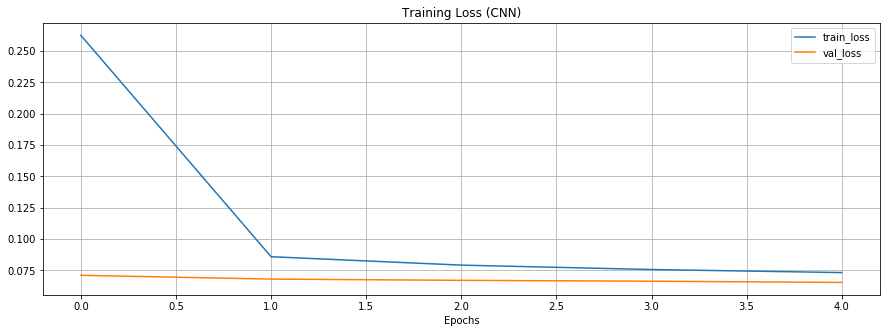

In [218]:
# Ploting the loss 

plt.figure(figsize=(15,5))
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.title("Training Loss (CNN)")
plt.xlabel("Epochs")
plt.grid()
#plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

### CNN+BiLSTM Model Results

#### Top 1 label prediction

In [33]:
pred_classes = get_pred_classes(X_test_seq, number_of_labels = 1)
print("precision:" , metrics.precision_score(Y_test, pred_classes, average = 'samples'))
print("recall:" , metrics.recall_score(Y_test, pred_classes, average = 'samples'))
print("f1:" , metrics.f1_score(Y_test, pred_classes, average = 'samples'))

precision: 0.2032619123760793
recall: 0.15980066091035072
f1: 0.17248815995857888


#### Top 2 labels prediction

In [57]:
pred_classes = get_pred_classes(X_test_seq, number_of_labels = 2)
print("precision:" , metrics.precision_score(Y_test, pred_classes, average = 'samples'))
print("recall:" , metrics.recall_score(Y_test, pred_classes, average = 'samples'))
print("f1:" , metrics.f1_score(Y_test, pred_classes, average = 'samples'))

precision: 0.17125039974416373
recall: 0.2624475002664961
f1: 0.1987337627727778


#### Top 5 labels prediction

In [58]:
pred_classes = get_pred_classes(X_test_seq, number_of_labels = 5)
print("precision:" , metrics.precision_score(Y_test, pred_classes, average = 'samples'))
print("recall:" , metrics.recall_score(Y_test, pred_classes, average = 'samples'))
print("f1:" , metrics.f1_score(Y_test, pred_classes, average = 'samples'))

precision: 0.11737767828589703
recall: 0.44188785843726686
f1: 0.1794488122118439


#### Top 10 labels prediction

In [35]:
pred_classes = get_pred_classes(X_test_seq, number_of_labels = 10)
print("precision:" , metrics.precision_score(Y_test, pred_classes, average = 'samples'))
print("recall:" , metrics.recall_score(Y_test, pred_classes, average = 'samples'))
print("f1:" , metrics.f1_score(Y_test, pred_classes, average = 'samples'))

precision: 0.08280780300607611
recall: 0.6142831254663681
f1: 0.14269271768632177


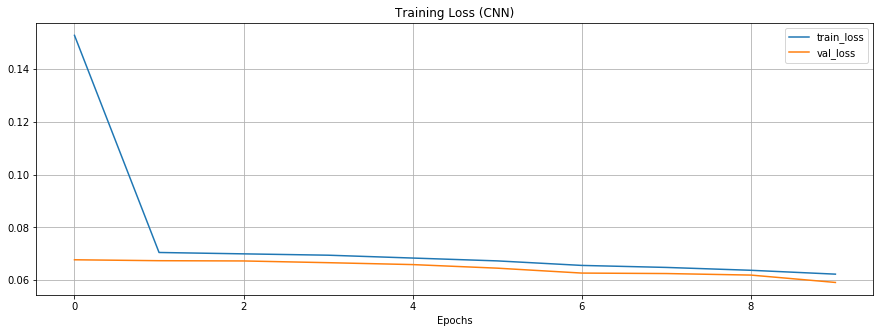

In [36]:
# Ploting the loss 

plt.figure(figsize=(15,5))
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.title("Training Loss (CNN)")
plt.xlabel("Epochs")
plt.grid()
#plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

### CNN+BiLSTM Model Results with our trained word2vec embeddings

#### Top 1 label prediction

In [95]:
print("Test Set: ")
pred_classes = get_pred_classes(X_test_seq, number_of_labels = 1)
print("precision:" , metrics.precision_score(Y_test, pred_classes, average = 'samples'))
print("recall:" , metrics.recall_score(Y_test, pred_classes, average = 'samples'))
print("f1:" , metrics.f1_score(Y_test, pred_classes, average = 'samples'))

precision: 0.24643428205948192
recall: 0.1944206374586931
f1: 0.20966391033548054


In [102]:
print("Train Set: ")
pred_classes = get_pred_classes(X_train_seq, number_of_labels = 1)
print("precision:" , metrics.precision_score(Y_train, pred_classes, average = 'samples'))
print("recall:" , metrics.recall_score(Y_train, pred_classes, average = 'samples'))
print("f1:" , metrics.f1_score(Y_train, pred_classes, average = 'samples'))

Train Set: 
precision: 0.24459120200841103
recall: 0.19058500225009653
f1: 0.20646028979415612


#### Top 2 labels prediction

In [99]:
pred_classes = get_pred_classes(X_test_seq, number_of_labels = 2)
print("precision:" , metrics.precision_score(Y_test, pred_classes, average = 'samples'))
print("recall:" , metrics.recall_score(Y_test, pred_classes, average = 'samples'))
print("f1:" , metrics.f1_score(Y_test, pred_classes, average = 'samples'))

precision: 0.2024944035817077
recall: 0.31487748793153336
f1: 0.23682615824285153


#### Top 10 labels prediction

In [100]:
pred_classes = get_pred_classes(X_test_seq, number_of_labels = 10)
print("precision:" , metrics.precision_score(Y_test, pred_classes, average = 'samples'))
print("recall:" , metrics.recall_score(Y_test, pred_classes, average = 'samples'))
print("f1:" , metrics.f1_score(Y_test, pred_classes, average = 'samples'))

precision: 0.08488007675087944
recall: 0.6311168471226034
f1: 0.1463372653857802


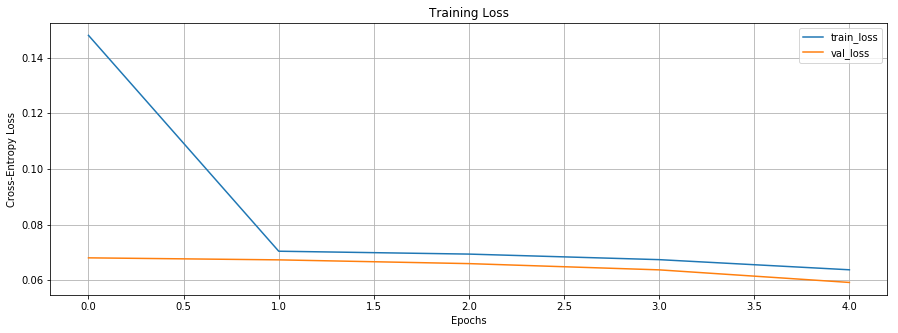

In [101]:
# Ploting the loss 

plt.figure(figsize=(15,5))
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.grid()
plt.ylabel("Cross-Entropy Loss")
plt.legend(loc="upper right")

### CapsNet Model Results 

#### Top 1 label prediction

In [204]:
pred_classes = get_pred_classes(X_test_seq, number_of_labels = 1)
print("precision:" , metrics.precision_score(Y_test, pred_classes, average = 'samples'))
print("recall:" , metrics.recall_score(Y_test, pred_classes, average = 'samples'))
print("f1:" , metrics.f1_score(Y_test, pred_classes, average = 'samples'))

precision: 0.08666453469779341
recall: 0.07351348470312333
f1: 0.07752691610702483


#### Top 2 labels prediction

In [206]:
pred_classes = get_pred_classes(X_test_seq, number_of_labels = 2)
print("precision:" , metrics.precision_score(Y_test, pred_classes, average = 'samples'))
print("recall:" , metrics.recall_score(Y_test, pred_classes, average = 'samples'))
print("f1:" , metrics.f1_score(Y_test, pred_classes, average = 'samples'))

precision: 0.0902782219379597
recall: 0.14362967700671567
f1: 0.1066550931213547


#### Top 10 labels prediction

In [207]:
pred_classes = get_pred_classes(X_test_seq, number_of_labels = 10)
print("precision:" , metrics.precision_score(Y_test, pred_classes, average = 'samples'))
print("recall:" , metrics.recall_score(Y_test, pred_classes, average = 'samples'))
print("f1:" , metrics.f1_score(Y_test, pred_classes, average = 'samples'))

precision: 0.05735209465941798
recall: 0.4347606864939772
f1: 0.09914317480834911


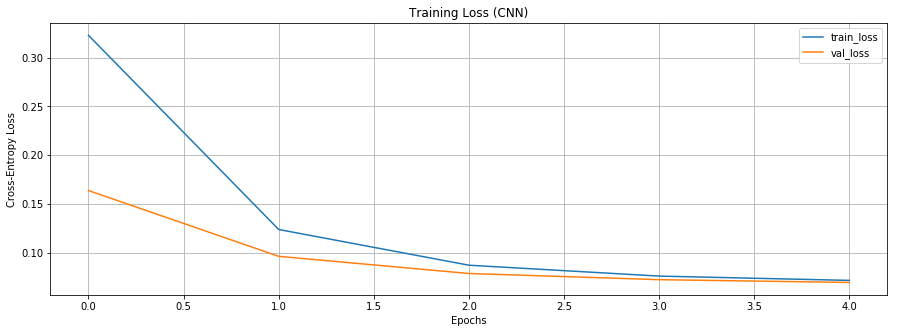

In [208]:
# Ploting the loss 

plt.figure(figsize=(15,5))
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.title("Training Loss (CNN)")
plt.xlabel("Epochs")
plt.grid()
plt.ylabel("Cross-Entropy Loss")
plt.legend(loc="upper right")

### Error Analysis

In [ ]:
def get_df_with_results(labels=1):
    pred_proba = model.predict(X_test_seq)
    all_labels = mlb.classes_
    pred_classes = get_pred_classes(X_test_seq, number_of_labels = labels)

    # Getting the predicted and actual labels in each patent in the test set
    predicted_labels = [all_labels[np.argsort(pred_proba[i])[::-1][:labels]] for i in range(pred_proba.shape[0])]
    actual_labels = [list(mlb.inverse_transform(Y_test)[i]) for i in range(pred_proba.shape[0])]

    # Getting the individual precisions and recalls
    precisions = [metrics.precision_score(Y_test[i], pred_classes[i]) for i in range(pred_proba.shape[0])]
    recalls = [metrics.recall_score(Y_test[i], pred_classes[i]) for i in range(pred_proba.shape[0])]
    
    # Creating a dataframe with all the results
    df_with_results = pd.DataFrame({'predicted_labels':predicted_labels,
                                  'actual_labels':actual_labels, 
                                  'precision':precisions, 
                                  'recall':recalls}, columns = ['predicted_labels','actual_labels','precision','recall'])
    
    return df_with_results


def calculate_total_scores(df_with_results):
    total_prec = round(df_with_results.precision.mean(),3)
    total_recall = round(df_with_results.recall.mean(),3)
    total_f1 = round(2*(total_prec*total_recall)/(total_prec+total_recall),3)
    return print("Precision: {}, Recall: {}, F1-score: {}".format(total_prec, total_recall, total_f1))

### CNN + BiLSTM

In [104]:
df_with_results = get_df_with_results(labels=5)
calculate_total_scores(df_with_results)

Precision: 0.117, Recall: 0.442, F1-score: 0.185


In [107]:
df_with_results.head(10)

,predicted_labels,actual_labels,precision,recall
0,"[f16l, f16d, f16b, f16c, f16k]",[f16l],0.2,1.0
1,"[f16h, f02d, f02b, f16k, f04b]",[f16f],0.0,0.0
2,"[f16l, f16b, f16d, f16h, f16c]",[f16l],0.2,1.0
3,"[f16h, f16d, f16f, f16l, f16b]",[f16h],0.2,1.0
4,"[f16l, f16b, f16d, f16c, f16h]",[f15b],0.0,0.0
5,"[f16k, f04b, f21v, f16l, f02b]","[f16j, f28f]",0.0,0.0
6,"[f16k, f02m, f02b, f04b, f28f]",[f16p],0.0,0.0
7,"[f02d, f02b, f02m, f25b, f01n]","[f02b, f02d, f02m]",0.6,1.0
8,"[f16l, f16b, f16d, f16h, f16c]",[f41j],0.0,0.0
9,"[f02d, f02b, f16k, f02m, f04b]","[f01l, f02d]",0.2,0.5


### CNN + BiLSTM with balanced classes

In [ ]:
df_with_results = get_df_with_results(labels=5)
calculate_total_scores(df_with_results)

In [ ]:
df_with_results.head(10)